In [54]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from time import time

../static/data/img/8197.jpeg
../static/data/img/8191.jpeg
../static/data/img/8206.jpeg
../static/data/img/8195.jpeg
../static/data/img/8176.jpeg
../static/data/img/8181.jpeg
Rectangle 0 area: 1989
Rectangle 0 area: 2295


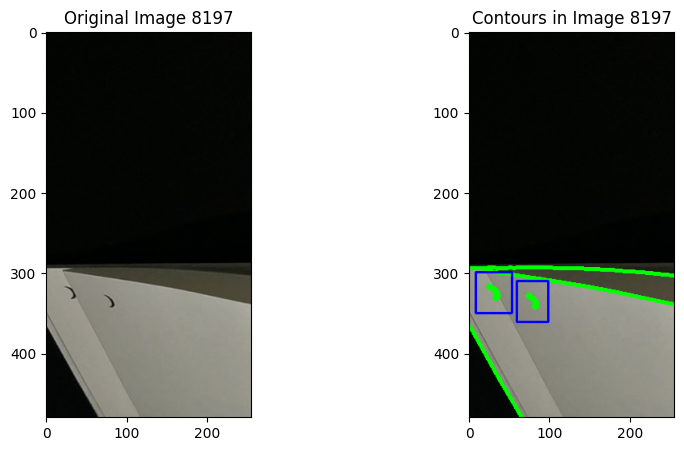

Rectangle 1 area: 2160


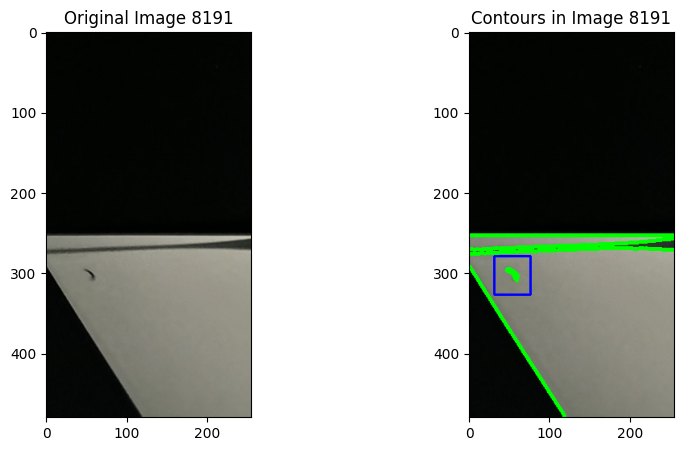

Rectangle 2 area: 2448


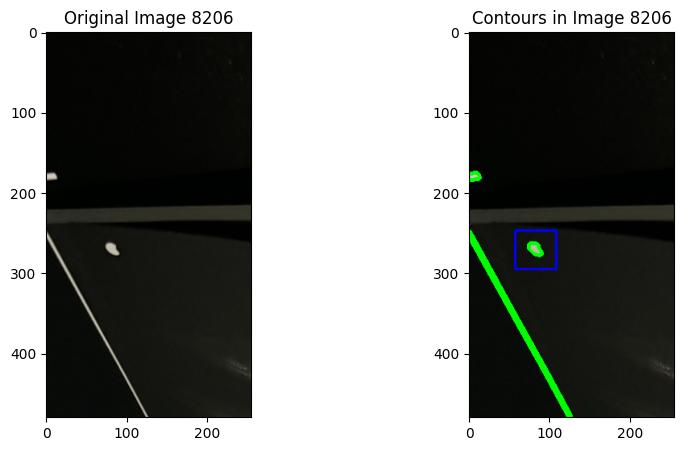

Rectangle 3 area: 3060


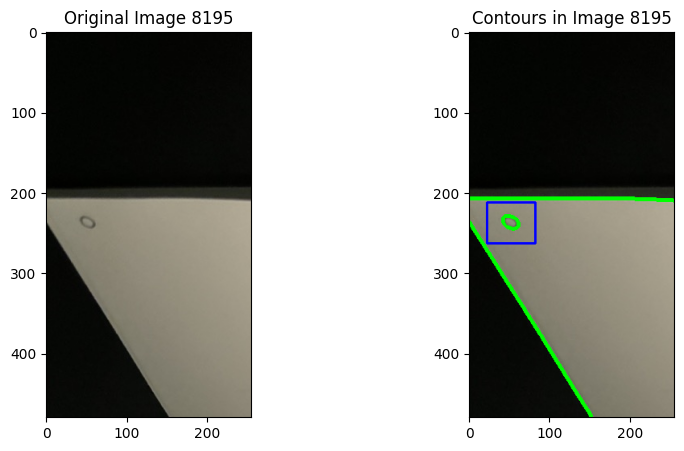

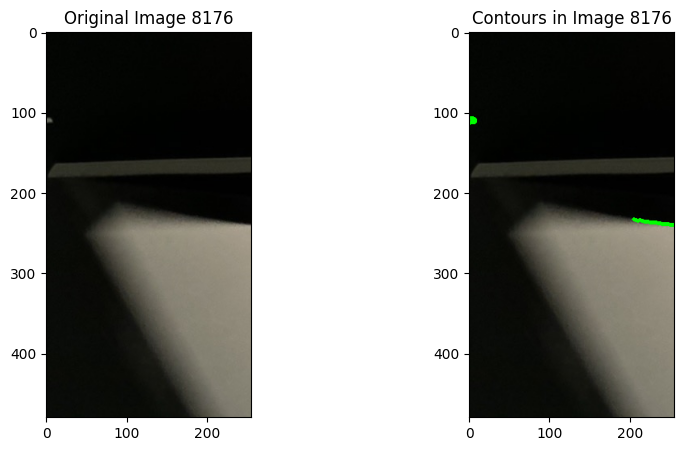

Rectangle 5 area: 1512
Rectangle 5 area: 108


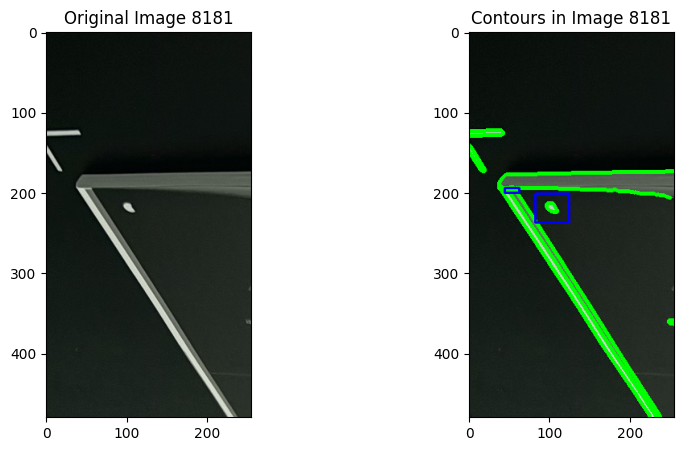

In [146]:
feed_examples = ['8197','8191', '8206', '8195', '8176', '8181']
feed_paths = [f'../static/data/img/{f}.jpeg' for f in feed_examples]


def load_image(img:str):
    img = cv2.imread(img)
    # crop top left
    height, width = img.shape[:2]
    crop_height = int(height * 0.5)
    crop_width = int(width * 0.8)
    cropped_img = img[crop_height:, crop_width:]
    # flip horizontally
    cropped_img = cv2.rotate(cropped_img, cv2.ROTATE_180)
    return cropped_img

def preprocess_image(img:cv2.Mat):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges


imgs = []
contours = []
rect_contours = []
for path in feed_paths:
    print(path)
    img = load_image(path)
    imgs.append(img)
    pp_img = preprocess_image(img)
    cnts, _ = cv2.findContours(pp_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours.append(cnts)
    # draw rectangles around contours
    rects = [cv2.boundingRect(cnt) for cnt in cnts]
    good_rects = []
    for i, rect in enumerate(rects):
        # expand by constant factor
        x, y, w, h = rect
        factor = 3
        x = int(x - (w * (factor - 1) / 2))
        y = int(y - (h * (factor - 1) / 2))
        w = int(w * factor)
        h = int(h * factor)
        # check if rectangle goes out of bounds, if do, dont add it
        if x < 0 or y < 0 or x + w > img.shape[1] or y + h > img.shape[0]:
            continue

        good_rects.append((x, y, w, h))
        

    
    rect_contours.append(good_rects)

for i, img in enumerate(imgs):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {feed_examples[i]}')
    
    plt.subplot(1, 2, 2)
    cv2.drawContours(img, contours[i], -1, (0, 255, 0), 3)
    for rect in rect_contours[i]:
        x, y, w, h = rect
        # print area
        area = w * h
        print(f'Rectangle {i} area: {area}')
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Contours in Image {feed_examples[i]}')
    
    plt.show()

In [175]:
import numpy as np

In [147]:
ref_path = '../static/icon_ref' 
refs = ['darkness','discover','enlightenment']
refs = [f'{ref_path}/{f}.png' for f in refs]

imgs = [load_image(f) for f in feed_paths]

ref_imgs = []
for ref in refs:
    ref_img = cv2.imread(ref)
    gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
    ref_imgs.append(gray)

1.3298400874807745
0.2983401220217128
0.2983401220217128


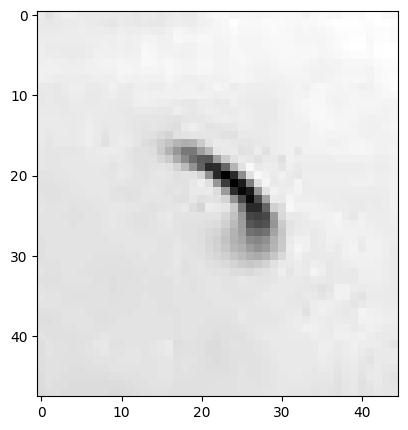

In [173]:
# get image inside rectangles
idx = 1
rect = rect_contours[idx][0]  # example for the first image
img= imgs[idx]
rect_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
cnts = contours[idx][0]
plt.figure(figsize=(5, 5))
rect_img = cv2.cvtColor(rect_img, cv2.COLOR_BGR2GRAY)
plt.imshow(rect_img, cmap='gray')

resize_refs = [cv2.resize(r[0], (rect_img.shape[1], rect_img.shape[0])) for r in ref_imgs]
print(cv2.matchShapes(rect_img, resize_refs[0], 2, 0.0))
print(cv2.matchShapes(rect_img, resize_refs[1], 2, 0.0))
print(cv2.matchShapes(rect_img, resize_refs[2], 2, 0.0))

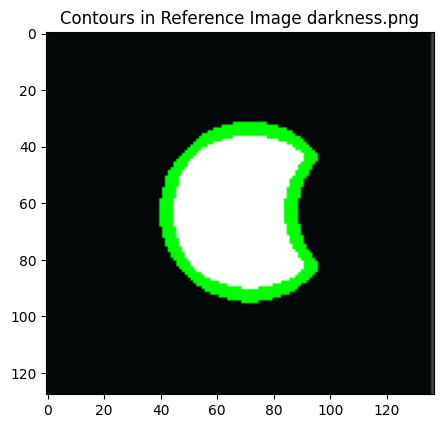

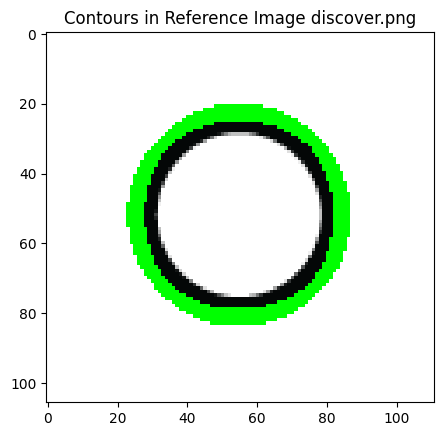

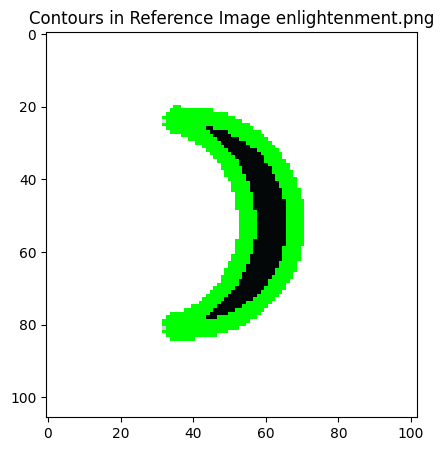

In [179]:
for ref_path in refs:
    ref_img = cv2.imread(ref_path)
    blur = cv2.GaussianBlur(ref_img, (5, 5), 0)
    edged = cv2.Canny(blur, 50, 150)
    cnts, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # plot 
    plt.figure(figsize=(5, 5))
    cv2.drawContours(ref_img, cnts, -1, (0, 255, 0), 3)
    plt.imshow(cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Contours in Reference Image {ref_path.split("/")[-1]}')
    plt.show()

Matches: 2


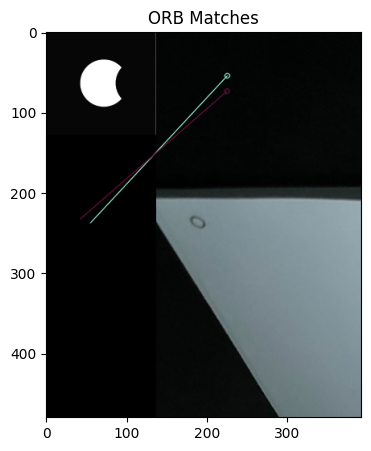

Matches: 1


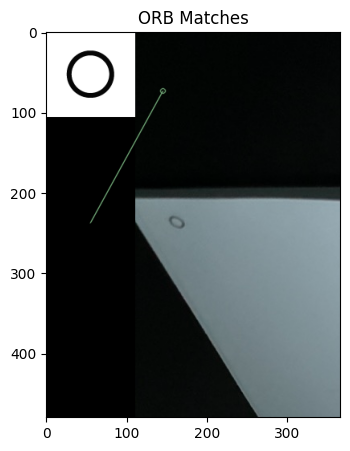

Matches: 3


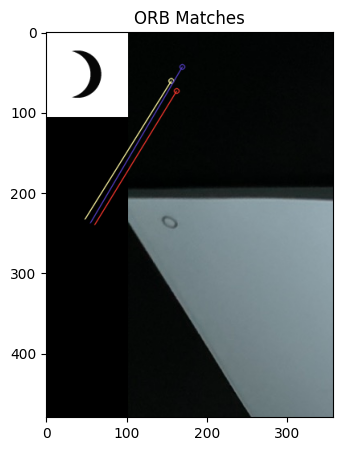

In [152]:
# use orb on rect_img and ref_imgs
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img, None)
for ref_img in ref_imgs:
    keypoints2, descriptors2 = orb.detectAndCompute(ref_img, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    print(f'Matches: {len(matches)}')
    img_matches = cv2.drawMatches(ref_img, keypoints1, img, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 5))
    plt.imshow(img_matches)
    plt.title('ORB Matches')
    plt.show()

In [ ]:
query = load_image(feed_paths[0])
reference = load_image(refs[1])
hist_query = cv2.calcHist([query], [0], None, [256], [0, 256])
hist_reference = cv2.calcHist([reference], [0], None, [256], [0, 256])
start = time()
cv2.normalize(hist_query, hist_query)
cv2.normalize(hist_reference, hist_reference)
cv2.compareHist(hist_query, hist_reference, cv2.HISTCMP_CORREL)

-0.011441483189476848

In [ ]:
# diff between two images using color histogram
def compare_images(img1, img2):
    

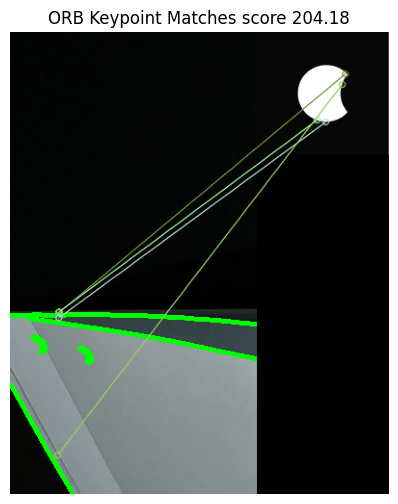

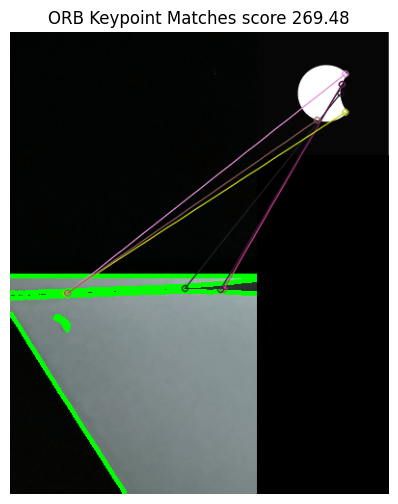

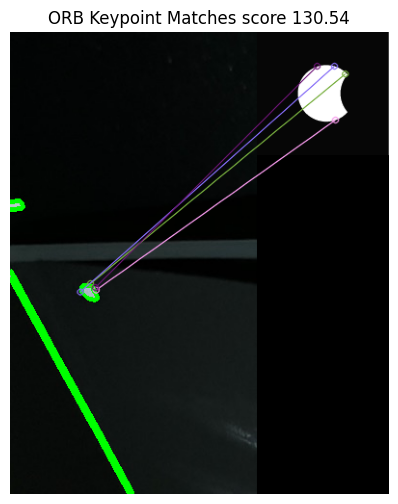

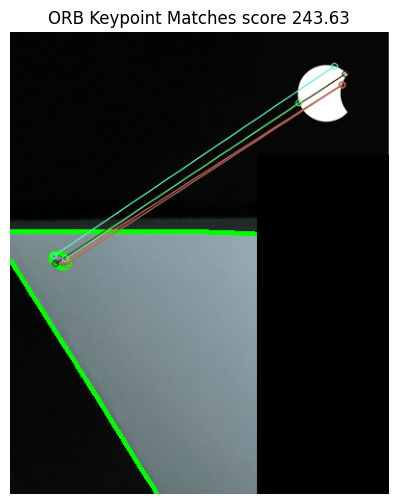

In [ ]:

for q in imgs:
    orb = cv2.ORB_create()
    kp_q, des_q = orb.detectAndCompute(q, None)
    kp_r, des_r = orb.detectAndCompute(ref_imgs[0], None)
    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors
    matches = bf.match(des_q, des_r)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    # Draw matches
    img_matches = cv2.drawMatches(q, kp_q, ref_imgs[0], kp_r, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    score = sum([m.distance for m in matches[:10]]) / 10
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches, cmap='gray')
    plt.title(f'ORB Keypoint Matches score {score:.2f}')
    plt.axis('off')

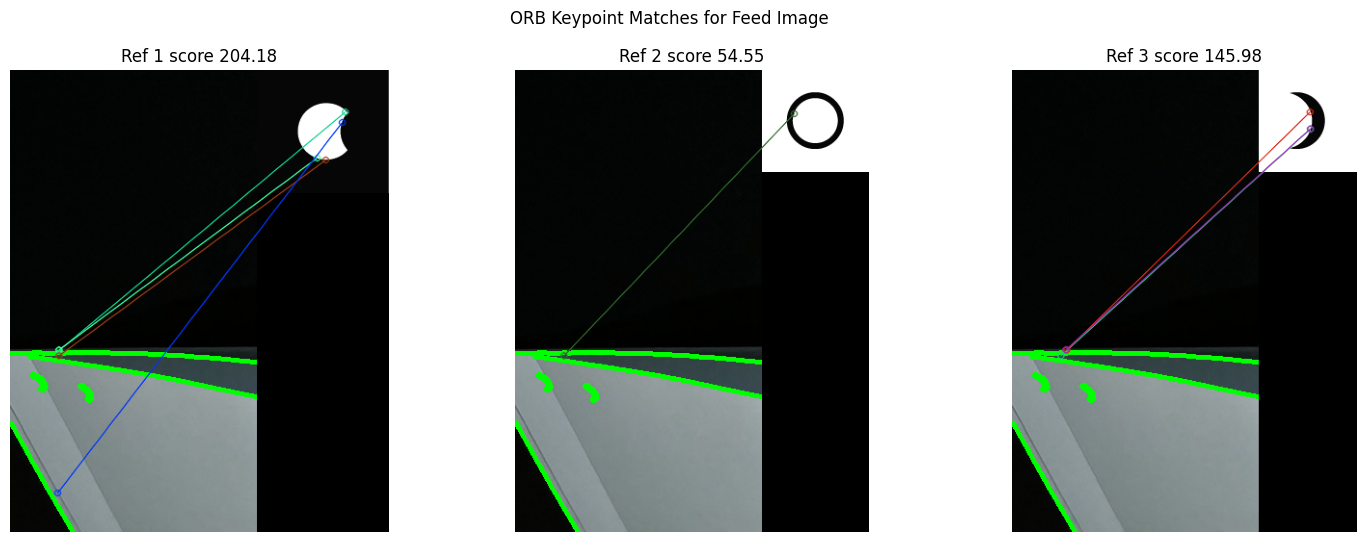

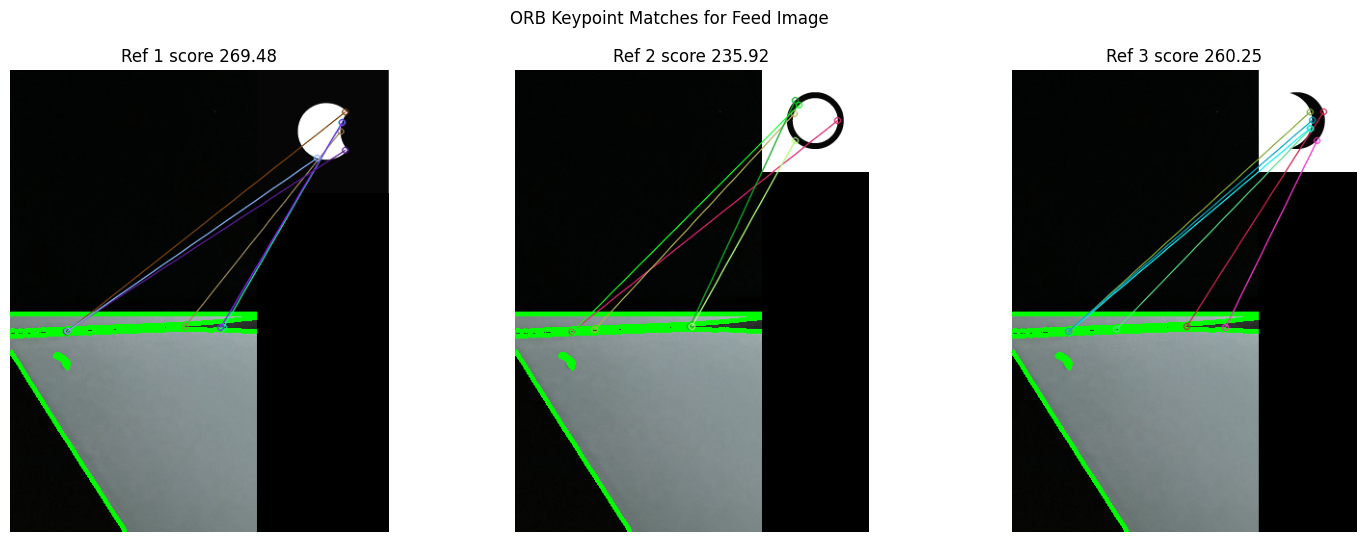

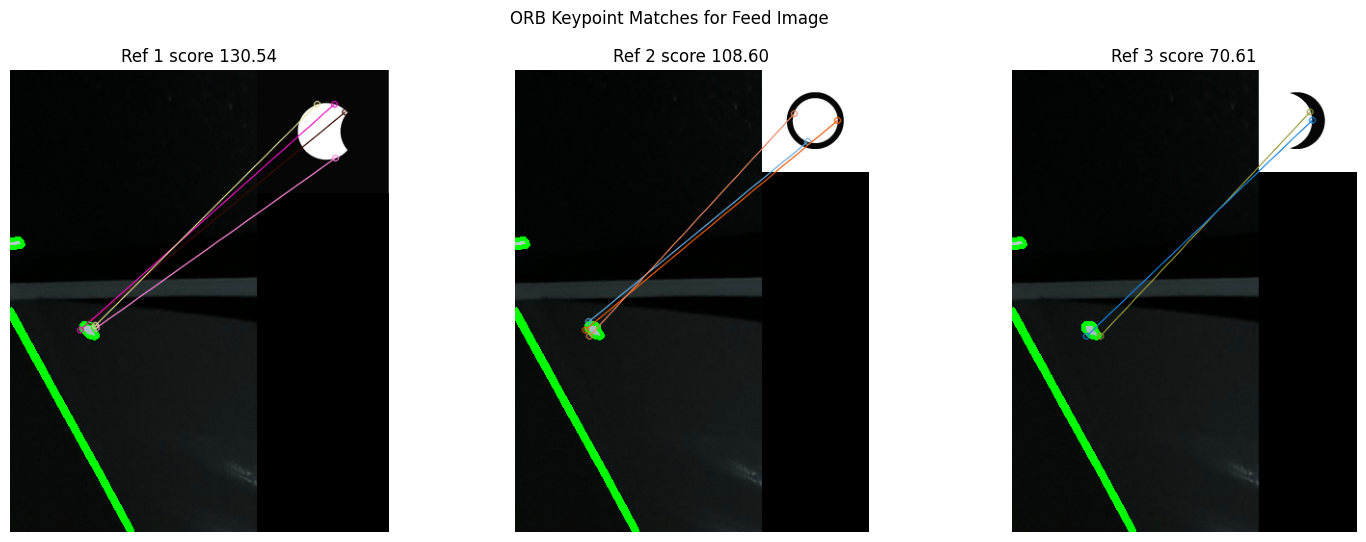

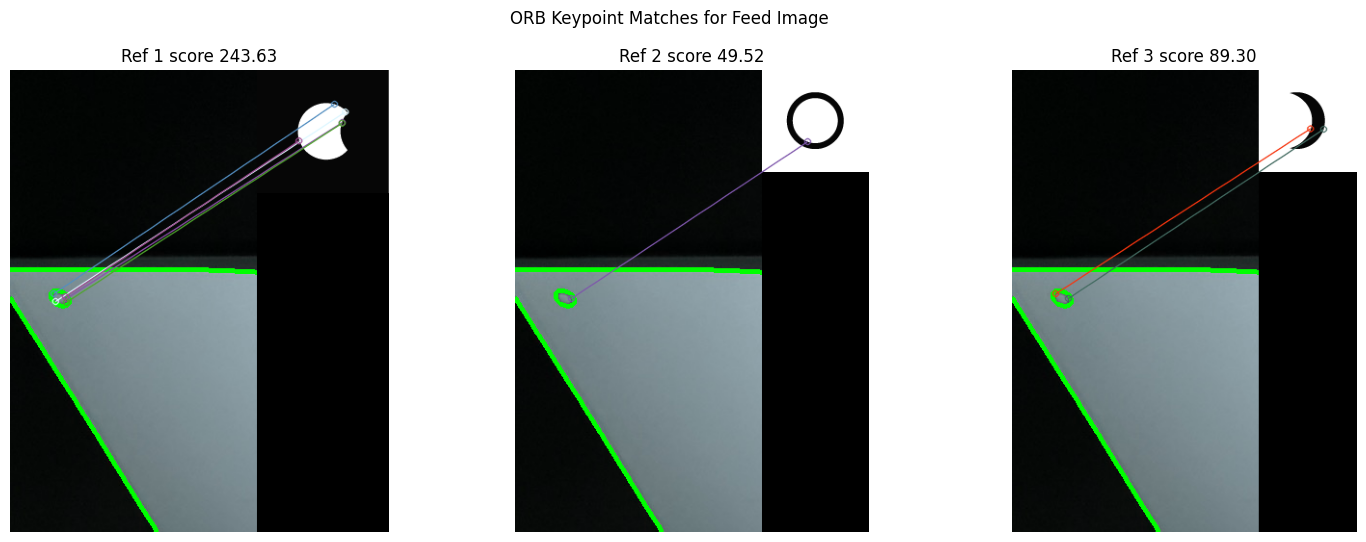

In [38]:
for q in imgs:
    plt.figure(figsize=(18, 6))
    for idx, ref_img in enumerate(ref_imgs):
        orb = cv2.ORB_create()
        kp_q, des_q = orb.detectAndCompute(q, None)
        kp_r, des_r = orb.detectAndCompute(ref_img, None)
        # Create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

        # Match descriptors
        matches = bf.match(des_q, des_r)

        # Sort matches by distance
        matches = sorted(matches, key=lambda x: x.distance)
        # Draw matches
        img_matches = cv2.drawMatches(q, kp_q, ref_img, kp_r, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        score = sum([m.distance for m in matches[:10]]) / 10
        plt.subplot(1, 3, idx + 1)
        plt.imshow(img_matches, cmap='gray')
        plt.title(f'Ref {idx+1} score {score:.2f}')
        plt.axis('off')
    plt.suptitle('ORB Keypoint Matches for Feed Image')
    plt.show()